In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

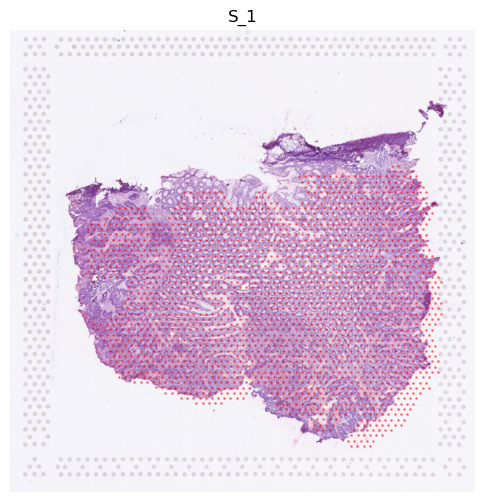

In [2]:
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

# Ad binary in Train dataset

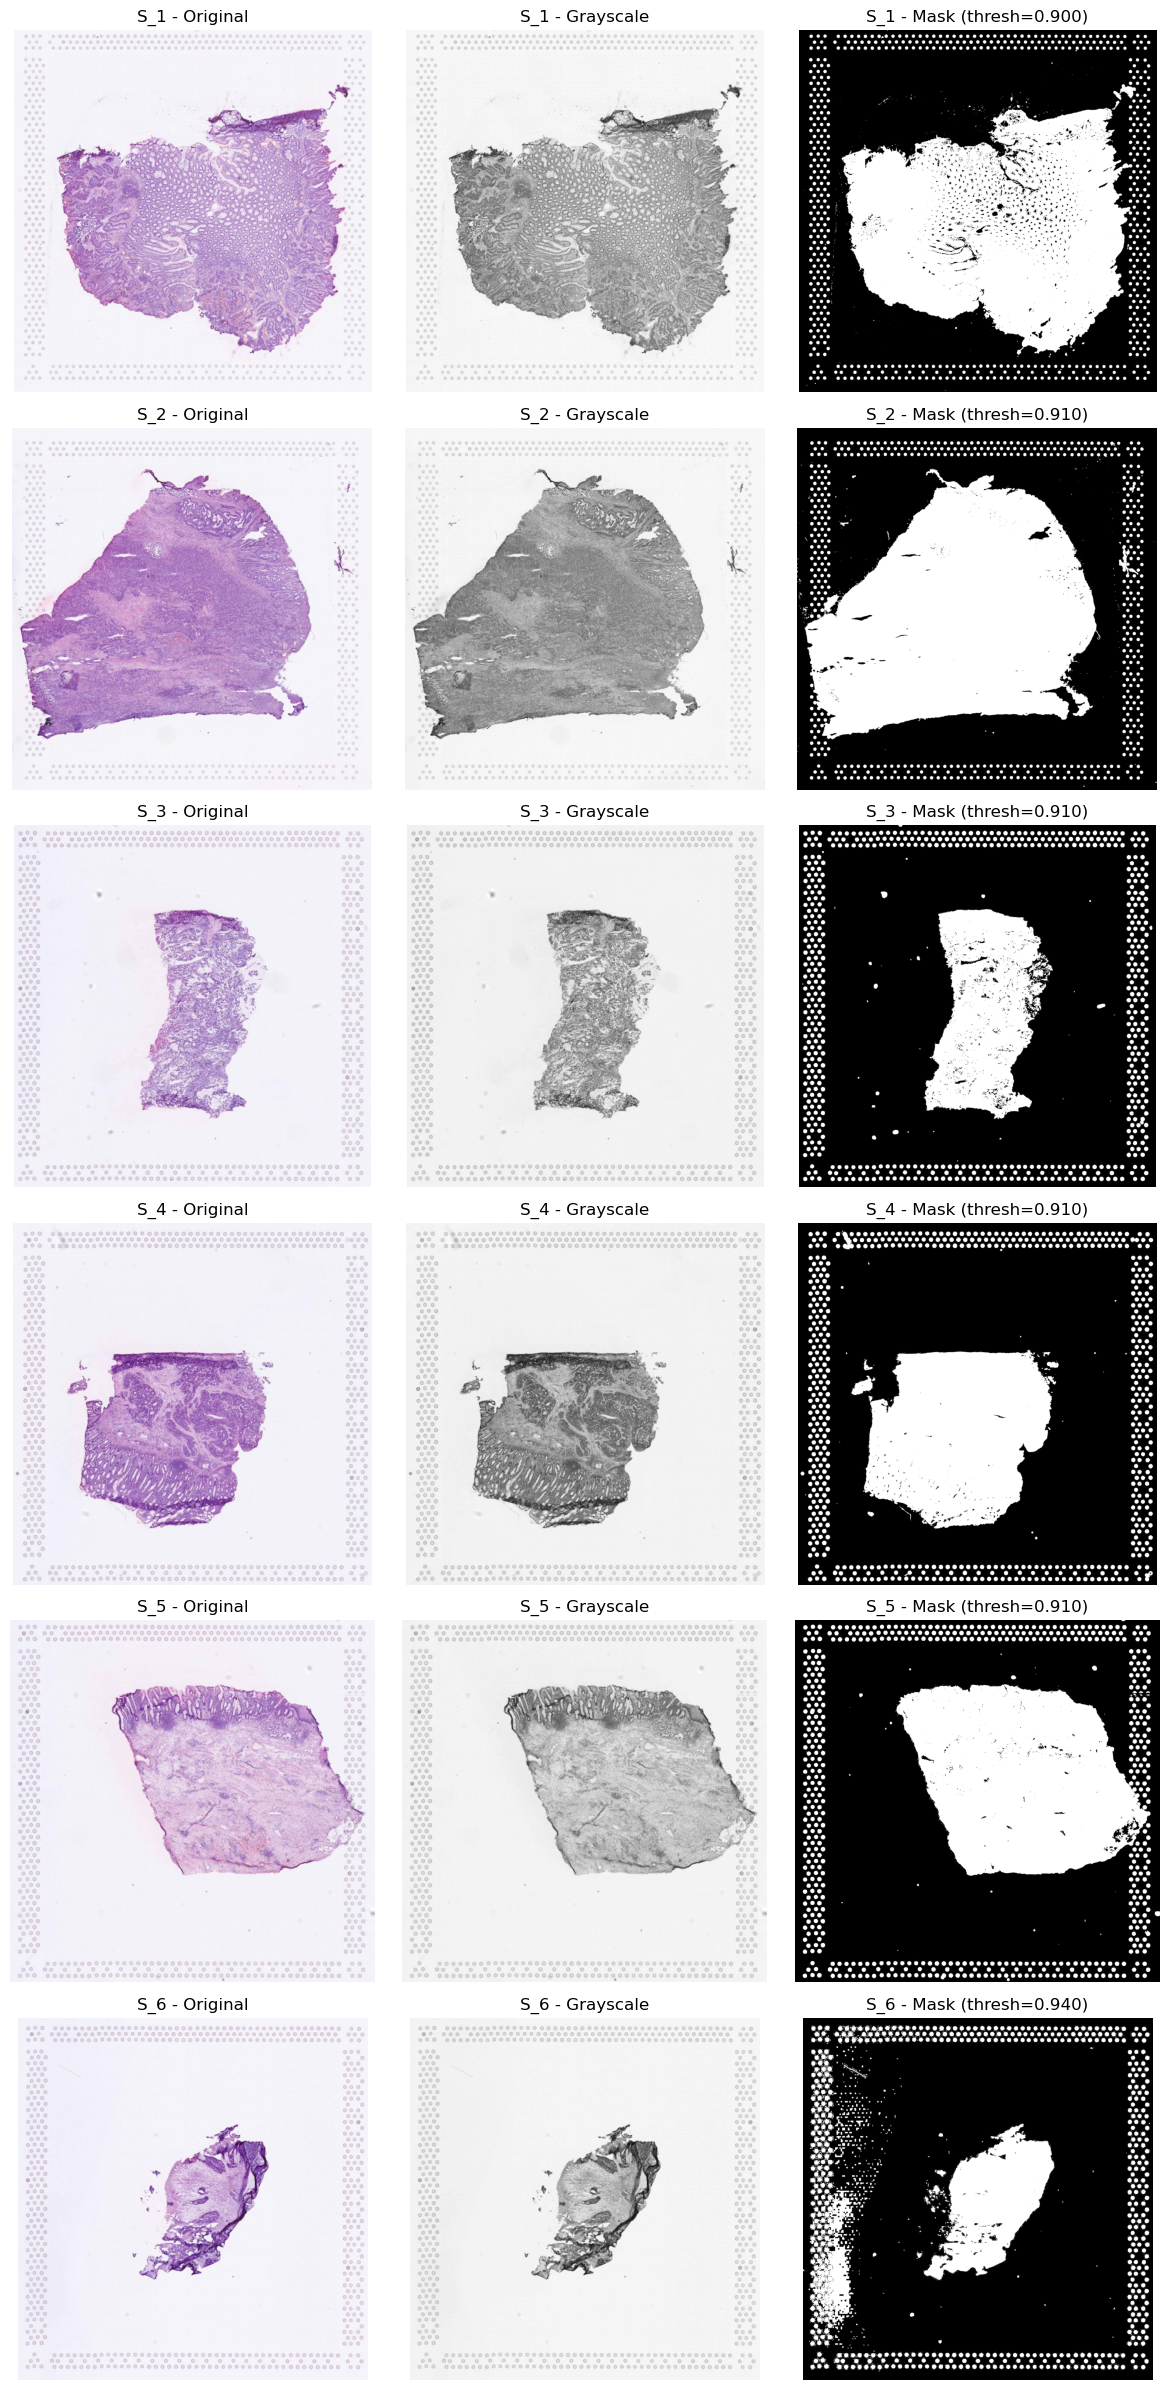

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
custom_thresholds = {
    "S_1": 0.90,
    "S_2": 0.91,
    "S_3": 0.91,
    "S_4": 0.91,
    "S_5": 0.91,
    "S_6": 0.94,
}
slide_masks = {}
slide_thresholds = {}
slide ={}
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_images.keys())

    n = len(slide_ids)
    fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(12, 4 * n))
    if n == 1:
        axs = [axs]

    for i, slide_id in enumerate(slide_ids):
        image = np.array(train_images[slide_id])
        gray_image = rgb2gray(image)

        # ✅ 使用自訂 threshold（如果沒有就 fallback）
        thresh = custom_thresholds.get(slide_id, threshold_mean(gray_image))
        binary_mask = (gray_image > thresh).astype(np.uint8)
        binary_mask = 1 - binary_mask

        slide[slide_id] = image
        slide_masks[slide_id] = binary_mask
        slide_thresholds[slide_id] = thresh

        axs[i][0].imshow(image)
        axs[i][0].set_title(f"{slide_id} - Original")
        axs[i][0].axis("off")

        axs[i][1].imshow(gray_image, cmap="gray")
        axs[i][1].set_title(f"{slide_id} - Grayscale")
        axs[i][1].axis("off")

        axs[i][2].imshow(binary_mask, cmap="gray")
        axs[i][2].set_title(f"{slide_id} - Mask (thresh={thresh:.3f})")
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.show()



In [4]:
import h5py
import numpy as np

# slide_masks 假設已經存在，是一個 dict：slide_id -> binary mask (np.array)
new_slide_masks = {}
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_images.keys())

    for slide_id in slide_ids:
        image = np.array(train_images[slide_id])  # shape: (H, W, 3)
        mask = slide_masks[slide_id].copy()  # ✅ 獨立副本

        # 👉 建立一個 image-level mask，判斷哪些 pixel 全部通道為 0
        image_zero_mask = np.all(image == 0, axis=-1)  # shape: (H, W), bool

        # ✅ 將 slide_mask 中那些對應 0 的地方也設為 0
        mask[image_zero_mask] = 0
        new_slide_masks[slide_id] = mask  # 更新回去（其實不用這行，原本就是 mutable）

        print(f"✔️ {slide_id} 已同步處理，0 區塊從 image -> mask 傳遞完成。")


✔️ S_1 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_2 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_3 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_4 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_5 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_6 已同步處理，0 區塊從 image -> mask 傳遞完成。


Text(0.5, 1.0, 'Mask After Aligning with Image Zero')

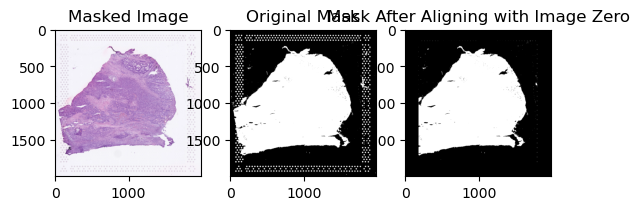

In [7]:
slide_id = 'S_2'
plt.subplot(1, 3, 1)
plt.imshow(slide[slide_id])
plt.title("Masked Image")

plt.subplot(1, 3, 2)
plt.imshow(slide_masks[slide_id] , cmap="gray")
plt.title("Original Mask")

plt.subplot(1, 3, 3)
plt.imshow(new_slide_masks[slide_id], cmap="gray")
plt.title("Mask After Aligning with Image Zero")


In [6]:
print(slide[slide_id].shape)

(2000, 1974, 3)


Slide ID: S_1
  Original image shape: (2000, 1974, 3)
  Mask shape: (2000, 1974)
  Masked image shape: (2000, 1974, 3)


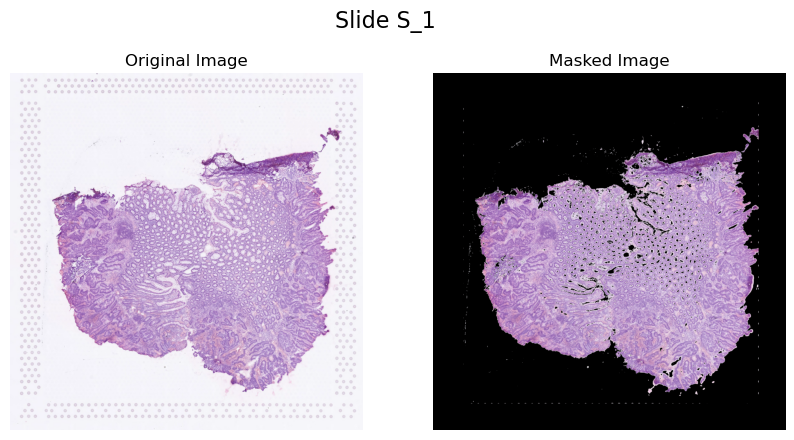

Slide ID: S_2
  Original image shape: (2000, 1988, 3)
  Mask shape: (2000, 1988)
  Masked image shape: (2000, 1988, 3)


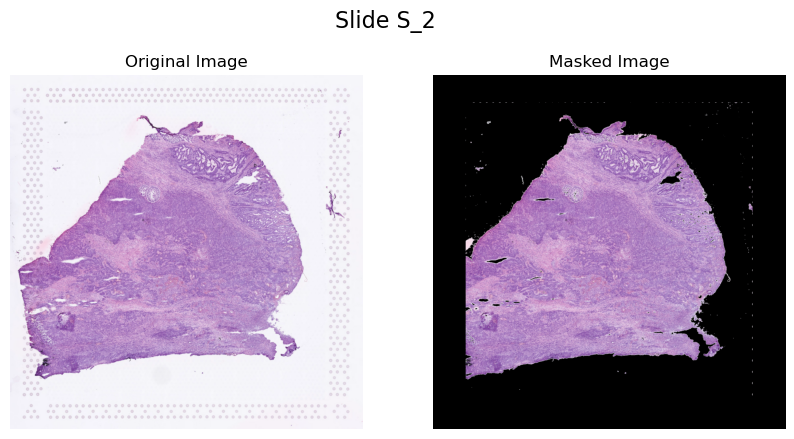

Slide ID: S_3
  Original image shape: (2000, 1966, 3)
  Mask shape: (2000, 1966)
  Masked image shape: (2000, 1966, 3)


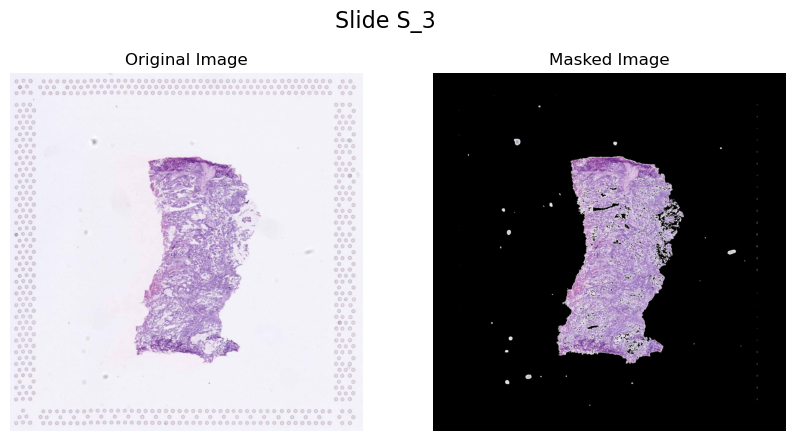

Slide ID: S_4
  Original image shape: (2000, 1979, 3)
  Mask shape: (2000, 1979)
  Masked image shape: (2000, 1979, 3)


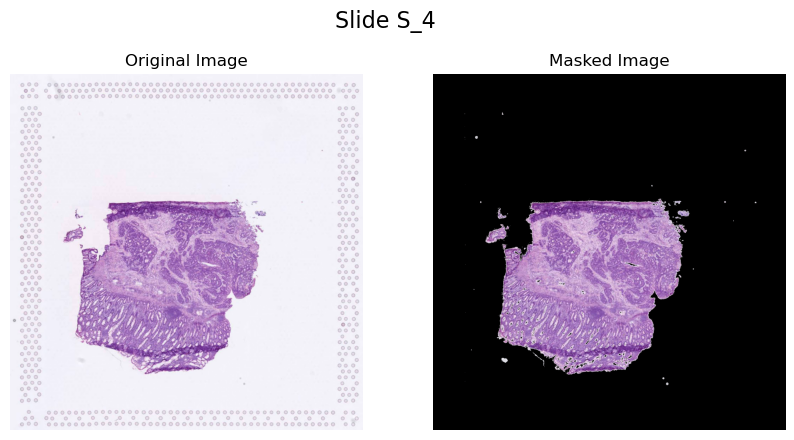

Slide ID: S_5
  Original image shape: (1985, 2000, 3)
  Mask shape: (1985, 2000)
  Masked image shape: (1985, 2000, 3)


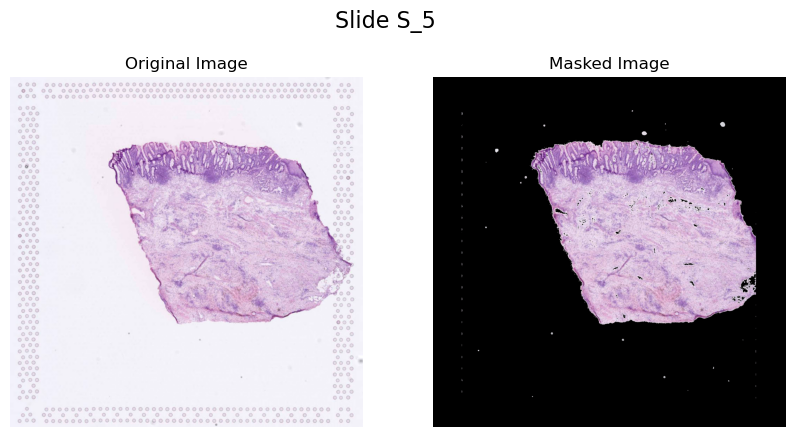

Slide ID: S_6
  Original image shape: (2000, 1930, 3)
  Mask shape: (2000, 1930)
  Masked image shape: (2000, 1930, 3)


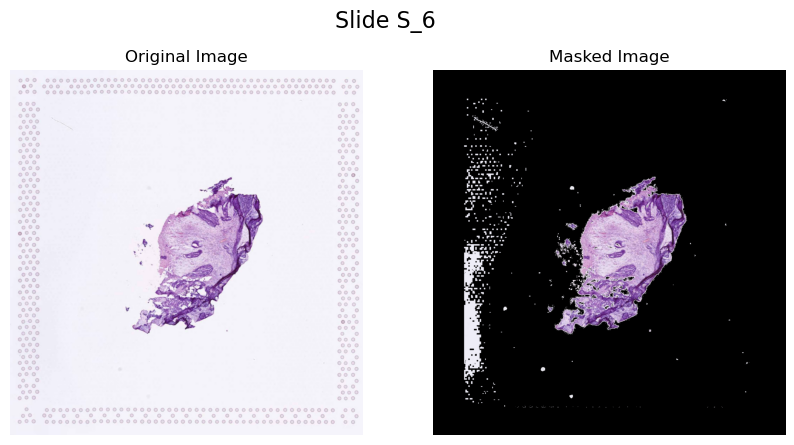

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming slide and new_slide_masks are already defined as dictionaries:
# slide: slide_id -> image array of shape (H, W, 3)
# new_slide_masks: slide_id -> mask array of shape (H, W)

for slide_id, image in slide.items():
    mask = new_slide_masks[slide_id]
    
    # Create masked image by applying mask
    # Assuming mask values are 0 or 1; if not, normalize mask to [0,1]
    mask_bool = mask.astype(bool)
    masked_image = image.copy()
    masked_image[~mask_bool] = 0  # zero-out regions where mask is False
    
    # Print shapes
    print(f"Slide ID: {slide_id}")
    print(f"  Original image shape: {image.shape}")
    print(f"  Mask shape: {mask.shape}")
    print(f"  Masked image shape: {masked_image.shape}")
    
    # Plot before and after
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(masked_image)
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    
    plt.suptitle(f"Slide {slide_id}", fontsize=16)
    plt.show()


In [9]:
import h5py
import numpy as np

# 1) 路径
output_path = "./dataset/masked_images_train.h5"

# 2) 打开要写入的 HDF5

with h5py.File(output_path, "w") as f_out:
    img_grp = f_out.create_group("images/Train")

    for slide_id, image in slide.items():
        mask = new_slide_masks[slide_id]            # shape=(H,W), 0/1
        mask_3ch = np.expand_dims(mask, -1)         # (H,W,1)
        masked_image = image * mask_3ch             # still float [0,1], shape=(H,W,3)

        # 强制成 float32 存储（HDF5 默认会用 float64）
        img_grp.create_dataset(
            slide_id,
            data=masked_image.astype(np.float32),
            compression="gzip", compression_opts=4
        )
        print(f"✔️ 已儲存 masked {slide_id} → shape {masked_image.shape}, dtype={masked_image.dtype}")

print(f"\n✅ 所有 masked-only 圖像（0–1 浮点）已儲存到：{output_path}")


✔️ 已儲存 masked S_1 → shape (2000, 1974, 3), dtype=float32
✔️ 已儲存 masked S_2 → shape (2000, 1988, 3), dtype=float32
✔️ 已儲存 masked S_3 → shape (2000, 1966, 3), dtype=float32
✔️ 已儲存 masked S_4 → shape (2000, 1979, 3), dtype=float32
✔️ 已儲存 masked S_5 → shape (1985, 2000, 3), dtype=float32
✔️ 已儲存 masked S_6 → shape (2000, 1930, 3), dtype=float32

✅ 所有 masked-only 圖像（0–1 浮点）已儲存到：./dataset/masked_images_train.h5


# Ad binary in Test dataset

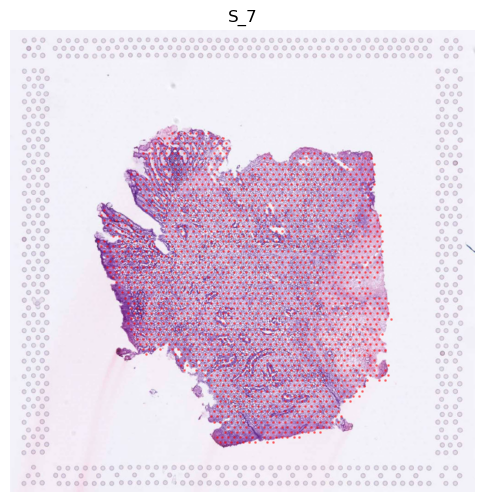

In [10]:
# Visualize Test slide ('S_7')
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    test_spots = h5file["spots/Test"]
    
    sample = 'S_7'
    image = np.array(test_images[sample])
    spots = np.array(test_spots[sample])
    x, y = spots["x"], spots["y"]

    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

0.8490186


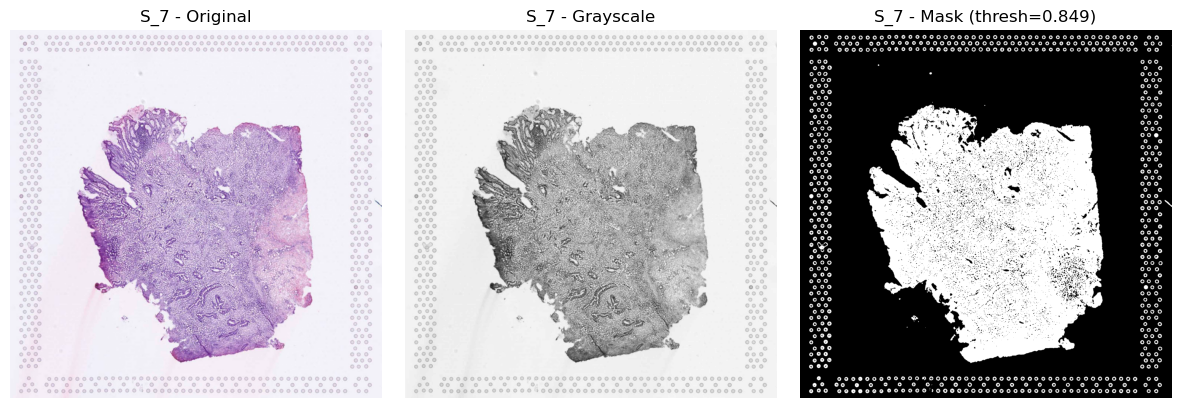

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
custom_thresholds = {
    
}
slide_masks = {}
slide_thresholds = {}
slide ={}
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Test"]
    slide_ids = list(train_images.keys())

    n = len(slide_ids)
    fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(12, 4 * n))
    if n == 1:
        axs = [axs]

    for i, slide_id in enumerate(slide_ids):
        image = np.array(train_images[slide_id])
        gray_image = rgb2gray(image)

        # ✅ 使用自訂 threshold（如果沒有就 fallback）
        thresh = custom_thresholds.get(slide_id, threshold_mean(gray_image))
        binary_mask = (gray_image > thresh).astype(np.uint8)
        binary_mask = 1 - binary_mask
        print(thresh)
        slide[slide_id] = image
        slide_masks[slide_id] = binary_mask
        slide_thresholds[slide_id] = thresh

        axs[i][0].imshow(image)
        axs[i][0].set_title(f"{slide_id} - Original")
        axs[i][0].axis("off")

        axs[i][1].imshow(gray_image, cmap="gray")
        axs[i][1].set_title(f"{slide_id} - Grayscale")
        axs[i][1].axis("off")

        axs[i][2].imshow(binary_mask, cmap="gray")
        axs[i][2].set_title(f"{slide_id} - Mask (thresh={thresh:.3f})")
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.show()



In [ ]:
combined_slide_images = {}  # slide_id -> (H, W, 4)

for slide_id in slide.keys():
    image = np.array(slide[slide_id])
    gray_image = rgb2gray(image)

    # ✅ 使用自訂 threshold（如果沒有就 fallback）
    thresh = custom_thresholds.get(slide_id, threshold_mean(gray_image))
    binary_mask = (gray_image > thresh).astype(np.uint8)
    binary_mask = 1 - binary_mask
    # Create masked image by applying mask
    # Assuming mask values are 0 or 1; if not, normalize mask to [0,1]
    mask_bool = binary_mask.astype(bool)
    masked_image = image.copy()
    masked_image[~mask_bool] = 0 
    
plt.figure(figsize=(8, 8))
plt.imshow(masked_image, cmap='gray')  # Mask 疊加
plt.title("S_1 - RGB + Mask Overlay")
plt.axis('off')
plt.show()


✔️ 合併完成: S_7 → shape (1983, 2000, 3)


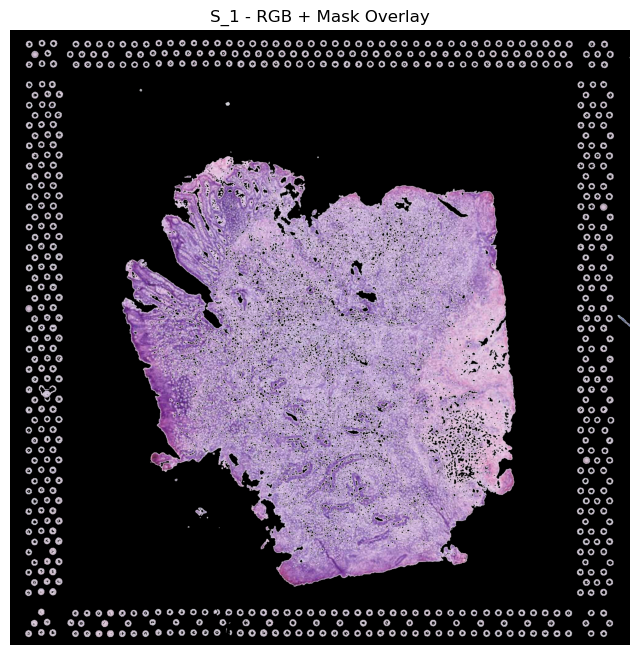

In [17]:
combined_slide_images = {}  # slide_id -> (H, W, 4)

for slide_id in slide.keys():
    image = slide[slide_id]                  # shape: (H, W, 3)
    mask = slide_masks[slide_id]         # shape: (H, W)
    mask_bool = mask.astype(bool)

    # ✅ 先把 mask 加一個通道軸，變成 (H, W, 1)
    masked_image = image.copy()
    masked_image[~mask_bool] = 0 
    # ✅ 合併成 (H, W, 4)

    combined_slide_images[slide_id] = masked_image
    print(f"✔️ 合併完成: {slide_id} → shape {masked_image.shape}")
plt.figure(figsize=(8, 8))
plt.imshow(combined_slide_images['S_7'], cmap='gray')  # Mask 疊加
plt.title("S_1 - RGB + Mask Overlay")
plt.axis('off')
plt.show()


In [18]:
import h5py
import numpy as np

output_path = "./dataset/masked_images_test.h5"

with h5py.File(output_path, "w") as f:
    image_group = f.create_group("images/Test")

    for slide_id, combined_img in combined_slide_images.items():
        image_group.create_dataset(slide_id, data=combined_img)
        print(f"✔️ 已儲存 {slide_id} → shape {combined_img.shape}")

print(f"\n✅ 所有圖像+mask 已儲存到：{output_path}")


✔️ 已儲存 S_7 → shape (1983, 2000, 3)

✅ 所有圖像+mask 已儲存到：./dataset/masked_images_test.h5
